# Exploratory Analysis and Data Cleaning

First we need to upload the data.

Download the data from:
https://tinyurl.com/kagglecfbdata

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import re
import os

foot = pd.read_csv("cfb13.csv")
print(foot)

                        Team  Games  Win  Loss  Off.Rank  Off.Plays  \
0                Akron (MAC)     12    5     7       106        837   
1              Alabama (SEC)     13   11     2        33        826   
2           Arizona (Pac-12)     13    8     5        31       1030   
3       Arizona St. (Pac-12)     14   10     4        32       1102   
4             Arkansas (SEC)     12    3     9        99        775   
..                       ...    ...  ...   ...       ...        ...   
106  Washington St. (Pac-12)     13    6     7        54        999   
107   West Virginia (Big 12)     12    4     8        62        892   
108   Western Ky. (Sun Belt)     12    8     4        30        875   
109      Western Mich. (MAC)     12    1    11       110        827   
110      Wisconsin (Big Ten)     13    9     4        18        912   

     Off.Yards  Off.Yards.Play  Off.TDs  Total.TDs  ...  \
0         4104            4.90       30         31  ...   
1         5903            7.1

In [2]:
def to_camel_case(column_name):
  #remove unnecesary characters and convert the string to camel case.
    words = re.split('[_,./\s-]', column_name)
    return words[0] + ''.join(word.capitalize() for word in words[1:])

In [3]:
# Creating the Combined Dataframe

folder_path = os.getcwd()
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

output_file_path = 'combined.csv'
combined_df = pd.DataFrame()
if os.path.exists(output_file_path):
    print(f"Combined CSV file already exists at {output_file_path}. Skipping combination.")
    combined_df = pd.read_csv(output_file_path)
    print(combined_df)
else:

# Loop through each CSV file and concatenate its data to the combined DataFrame
  for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    df.columns = [to_camel_case(col) for col in df.columns]
    if 'WinLoss' in df.columns:
        df[['Win', 'Loss']] = df['WinLoss'].str.split('-', expand=True).astype(int)
        df = df.drop(columns=['WinLoss'])
    combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Write the combined DataFrame to a new CSV file
    combined_df.to_csv(output_file_path, index=False)


print("number of teams x features: ",combined_df.info())

Combined CSV file already exists at combined.csv. Skipping combination.
                            Team  Games   Win  Loss  Off.Rank  Off.Plays  \
0                    Akron (MAC)     12   5.0   7.0      84.0      776.0   
1                  Alabama (SEC)     15  14.0   1.0      34.0     1056.0   
2     Appalachian St. (Sun Belt)     13  10.0   3.0      52.0      912.0   
3               Arizona (Pac-12)     12   3.0   9.0      67.0      815.0   
4           Arizona St. (Pac-12)     12   5.0   7.0      81.0      900.0   
...                          ...    ...   ...   ...       ...        ...   
1226     Washington St. (Pac-12)     13   9.0   4.0      25.0     1032.0   
1227      West Virginia (Big 12)     13   8.0   5.0      23.0     1051.0   
1228         Western Ky. (C-USA)     14  12.0   2.0       9.0     1019.0   
1229         Western Mich. (MAC)     13   8.0   5.0      17.0      930.0   
1230         Wisconsin (Big Ten)     13  10.0   3.0      79.0      931.0   

      Off.Yards

In [4]:
# Cleaning Up the Data

nan_threshold = 0.5 * len(combined_df)

# Drop columns with 50% or more NaN values
cleaned_df = combined_df.dropna(axis=1, thresh=nan_threshold)

nan_threshold = 0.5 * len(combined_df.columns)

# Drop rows with 50% or more NaN values
cleaned_df = cleaned_df.dropna(axis=0, thresh=nan_threshold)

# Set the "Team" column as the index
cleaned_df.set_index('Team', inplace=True)

# Removing any remaining NaN columns
nan_columns = cleaned_df.columns[cleaned_df.isna().any()].tolist()
cleaned_df = cleaned_df.drop(columns=nan_columns)

cleaned_df.rename(columns={col: to_camel_case(col) for col in cleaned_df.columns}, inplace=True)


print(cleaned_df)

                            Games   Win  Loss  OffRank  OffPlays  OffYards  \
Team                                                                         
Akron (MAC)                    12   5.0   7.0     84.0     776.0    4649.0   
Alabama (SEC)                  15  14.0   1.0     34.0    1056.0    6829.0   
Appalachian St. (Sun Belt)     13  10.0   3.0     52.0     912.0    5589.0   
Arizona (Pac-12)               12   3.0   9.0     67.0     815.0    4957.0   
Arizona St. (Pac-12)           12   5.0   7.0     81.0     900.0    4689.0   
...                           ...   ...   ...      ...       ...       ...   
West Virginia (Big 12)          9   5.0   4.0     42.0     690.0    3804.0   
Western Ky. (C-USA)            11   5.0   6.0    120.0     699.0    3200.0   
Western Mich. (MAC)             6   4.0   2.0     15.0     392.0    2878.0   
Wisconsin (Big Ten)             6   3.0   3.0     93.0     431.0    2153.0   
Wyoming (Mountain West)         6   2.0   4.0     82.0     409.0

In [5]:
# some more data cleanup; converting all columns in minute:second format

# Function to check if a value is in minute:second format
def is_minute_second_format(value):
    if isinstance(value, str):
        try:
            minutes, seconds = map(int, value.split(':'))
            return True
        except ValueError:
            pass
    return False

# Identify columns with values in minute:second format
time_columns = [col for col in cleaned_df.columns if cleaned_df[col].apply(is_minute_second_format).all()]

# Convert values in identified columns to total seconds
def convert_columns_to_seconds(df, columns):
    for column in columns:
        df[column] = df[column].apply(convert_to_seconds)

# Function to convert minute:second to total seconds
def convert_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Apply conversion to identified columns
convert_columns_to_seconds(cleaned_df, time_columns)
# Convert all columns with string values to floats
cleaned_df.replace(',', '', regex=True, inplace=True)
cleaned_df = cleaned_df.apply(pd.to_numeric, errors='ignore')
print(cleaned_df["AverageTimeOfPossessionPerGame"])

Team
Akron (MAC)                   1558
Alabama (SEC)                 1855
Appalachian St. (Sun Belt)    2015
Arizona (Pac-12)              1550
Arizona St. (Pac-12)          1811
                              ... 
West Virginia (Big 12)        1958
Western Ky. (C-USA)           1763
Western Mich. (MAC)           1695
Wisconsin (Big Ten)           2205
Wyoming (Mountain West)       1841
Name: AverageTimeOfPossessionPerGame, Length: 631, dtype: int64


In [6]:
# Find the rate of wins for each team
# We'll build a model predicting this win-rate
# In other words, we'll predict the percentage of games each team will win
cleaned_df["winRate"] = cleaned_df["Win"]/cleaned_df["Games"]
print(cleaned_df["winRate"])
print(cleaned_df.columns)

# Check for any more NaN columns
nan_columns = cleaned_df.columns[cleaned_df.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)

Team
Akron (MAC)                   0.416667
Alabama (SEC)                 0.933333
Appalachian St. (Sun Belt)    0.769231
Arizona (Pac-12)              0.250000
Arizona St. (Pac-12)          0.416667
                                ...   
West Virginia (Big 12)        0.555556
Western Ky. (C-USA)           0.454545
Western Mich. (MAC)           0.666667
Wisconsin (Big Ten)           0.500000
Wyoming (Mountain West)       0.333333
Name: winRate, Length: 631, dtype: float64
Index(['Games', 'Win', 'Loss', 'OffRank', 'OffPlays', 'OffYards',
       'OffYardsPlay', 'OffTds', 'OffYardsPerGame', 'DefRank',
       ...
       'TurnoverRank', 'FumblesRecovered', 'OpponentsIntercepted',
       'TurnoversGain', 'FumblesLost', 'InterceptionsThrownY', 'TurnoversLost',
       'TurnoverMargin', 'AvgTurnoverMarginPerGame', 'winRate'],
      dtype='object', length=152)
Columns with NaN values: []


In [7]:
# Create Training and Testing Dataframes
from sklearn.model_selection import train_test_split

## Split the data, df_adjusted into training (90%) and testing (10%) using sklearn

df_training, df_testing = train_test_split(cleaned_df, test_size=0.1, random_state=50)

print("df_training shape:", df_training.shape)
print("df_testing shape:", df_testing.shape)

df_training shape: (567, 152)
df_testing shape: (64, 152)


In [8]:
# Normalizing Training Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_training_scaled = scaler.fit_transform(df_training)
df_training_scaled = pd.DataFrame(df_training_scaled, columns=df_training.columns)

## Feature Selection

In [9]:
# Random Forest Implementation for Feature Selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Assuming you have a target variable 'target_column' that you want to predict
target_column = 'winRate'

# We will remove these columns from X observations dataframe
remove_columns = ['winRate', 'Win', 'Loss', 'Games']

# Split the features and target variable in df_training
X_train = df_training_scaled.drop(columns=remove_columns, axis=1)
y_train = df_training[target_column]

# Initialize the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest model on the training data
rf_regressor.fit(X_train, y_train)

# Use feature importance for feature selection
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances if needed
print("Feature Importances:")
print(feature_importance_df)

# Select features with importance above a certain threshold (you can adjust this threshold)
sfm = SelectFromModel(rf_regressor, threshold=0.1)  # Adjust threshold as needed
sfm.fit(X_train, y_train)

# Transform the training data to keep only the selected features
X_train_selected = sfm.transform(X_train)

# Print the selected feature names
selected_feature_names = X_train.columns[sfm.get_support()]
print("Selected Features:")
print(selected_feature_names)

Feature Importances:
                               Feature  Importance
112            AvgPointsPerGameAllowed    0.257624
121                      PointsPerGame    0.195663
104                     ScoringDefRank    0.194047
113                     ScoringOffRank    0.128186
120                        TotalPoints    0.025954
..                                 ...         ...
35             AvgYardPerKickoffReturn    0.000116
67                PuntReturnTouchdowns    0.000105
41   OppKickoffReturnTouchdownsAllowed    0.000057
117                    DefensivePoints    0.000038
108            OppDeflectedExtraPoints    0.000015

[148 rows x 2 columns]
Selected Features:
Index(['ScoringDefRank', 'AvgPointsPerGameAllowed', 'ScoringOffRank',
       'PointsPerGame'],
      dtype='object')


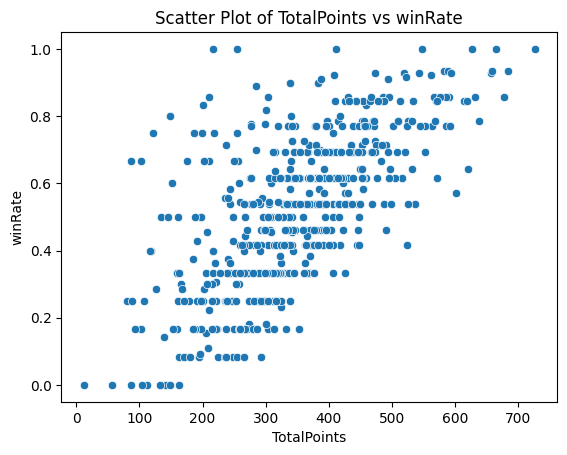

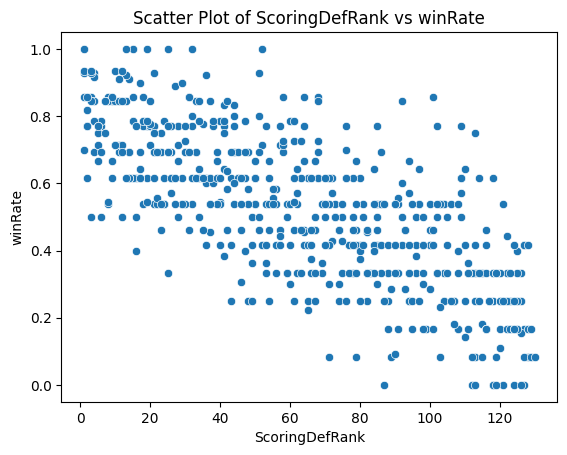

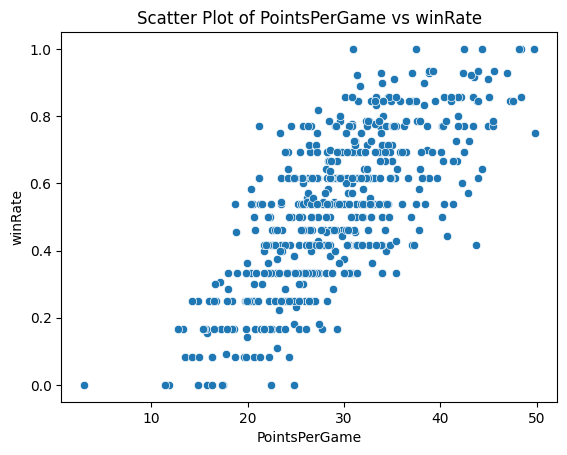

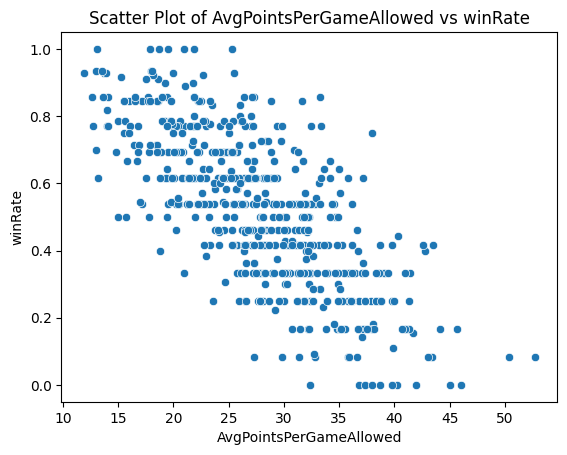

In [10]:
# Plotting the Top 4 Features

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="TotalPoints", y="winRate", data=df_training)
plt.title("Scatter Plot of TotalPoints vs winRate")
plt.show()

sns.scatterplot(x="ScoringDefRank", y="winRate", data=df_training)
plt.title("Scatter Plot of ScoringDefRank vs winRate")
plt.show()

sns.scatterplot(x="PointsPerGame", y="winRate", data=df_training)
plt.title("Scatter Plot of PointsPerGame vs winRate")
plt.show()

sns.scatterplot(x="AvgPointsPerGameAllowed", y="winRate", data=df_training)
plt.title("Scatter Plot of AvgPointsPerGameAllowed vs winRate")
plt.show()

#Linear Regression

##Gradient Descent

In [11]:
# Linear Regression, L2 Error, Gradient Descent Function Definitions
# we'll use the 4 features we plotted above

obsX = df_training_scaled[["TotalPoints","ScoringDefRank","PointsPerGame","AvgPointsPerGameAllowed"]]
obsY = df_training_scaled['winRate']

def h(obsX, theta0,theta1,theta2,theta3,theta4):
  return theta4*obsX["AvgPointsPerGameAllowed"] + theta3*obsX["PointsPerGame"] + theta2 * obsX["ScoringDefRank"] + theta1 * obsX["TotalPoints"] + theta0

def l2_error(y_pred, obsY):
  return np.mean((y_pred - obsY)**2)

def gradient_descent(obsX, obsY, alpha, threshold):

    theta0 = 0
    theta1 = 0
    theta2 = 0
    theta3 = 0
    theta4 = 0

    # Initial error
    y_pred = h(obsX, theta0,theta1,theta2,theta3,theta4)
    oldError = l2_error(y_pred, obsY)

    while True:
        # Update theta0 and theta1 simultaneously
        theta0=theta0 - alpha * (np.mean(theta4*obsX["AvgPointsPerGameAllowed"] + theta3*obsX["PointsPerGame"] + theta2 * obsX["ScoringDefRank"] + theta1 * obsX["TotalPoints"] + theta0 - obsY))
        theta1=theta1 - alpha * (np.mean((theta4*obsX["AvgPointsPerGameAllowed"] + theta3*obsX["PointsPerGame"] + theta2 * obsX["ScoringDefRank"] + theta1 * obsX["TotalPoints"] + theta0 - obsY) * obsX["TotalPoints"]))
        theta2=theta2 - alpha * (np.mean((theta4*obsX["AvgPointsPerGameAllowed"] + theta3*obsX["PointsPerGame"] + theta2 * obsX["ScoringDefRank"] + theta1 * obsX["TotalPoints"] + theta0 - obsY) * obsX["ScoringDefRank"]))
        theta3=theta3 - alpha * (np.mean((theta4*obsX["AvgPointsPerGameAllowed"] + theta3*obsX["PointsPerGame"] + theta2 * obsX["ScoringDefRank"] + theta1 * obsX["TotalPoints"] + theta0 - obsY) * obsX["PointsPerGame"]))
        theta4=theta4 - alpha * (np.mean((theta4*obsX["AvgPointsPerGameAllowed"] + theta3*obsX["PointsPerGame"] + theta2 * obsX["ScoringDefRank"] + theta1 * obsX["TotalPoints"] + theta0 - obsY) * obsX["AvgPointsPerGameAllowed"]))


        # Compute new error
        y_pred = h(obsX, theta0,theta1,theta2,theta3,theta4)
        newError = l2_error(y_pred, obsY)
        print("theta0:", theta0)
        print("theta1:", theta1)
        print("theta2:", theta2)
        print("theta3:", theta3)
        print("theta4:", theta4)
        print("New Error:", newError)

        # Check for convergence
        if abs(newError - oldError) < threshold:
            break

        # Update oldError for the next iteration
        oldError = newError

    return theta0, theta1,theta2,theta3,theta4, newError

## Fit the model

In [12]:
[theta0, theta1,theta2,theta3,theta4, newError] = gradient_descent(obsX,obsY,0.08,0.0001)
print("Final values:")
print("theta0:", theta0, "theta1:", theta1, "theta2:",theta2,"theta3:",theta3,"theta4:",theta4, "final error:", newError)

theta0: 0.041661296962884266
theta1: 0.020111097927636098
theta2: 0.014485792673900466
theta3: 0.022766506067320138
theta4: 0.011522908767480758
New Error: 0.24873777902518862
theta0: 0.07729049969280755
theta1: 0.037542060339854404
theta2: 0.026229647212833433
theta3: 0.042485400490310424
theta4: 0.020997360567188414
New Error: 0.1955295935456218
theta0: 0.10777778911361577
theta1: 0.05268632693081783
theta2: 0.03564221702623422
theta3: 0.05960444172803245
theta4: 0.02872918837741724
New Error: 0.15664775745337733
theta0: 0.13388180412792608
theta1: 0.06587921723293746
theta2: 0.043073419101189066
theta3: 0.0745052405422819
theta4: 0.03497900042634447
New Error: 0.12817757499128862
theta0: 0.15624908117770991
theta1: 0.07740651957382244
theta2: 0.04882141024643692
theta3: 0.0875130352884764
theta4: 0.039968863887432884
New Error: 0.10727538410262089
theta0: 0.17543062097075093
theta1: 0.08751181073396436
theta2: 0.053140236796882886
theta3: 0.09890502258737138
theta4: 0.04388800083656

In [13]:
# for comparison to gradient descent, this is a library estimator to determine coefficients

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

scaler = MinMaxScaler()
df_testing_scaled = scaler.fit_transform(df_testing)
df_testing_scaled = pd.DataFrame(df_testing_scaled, columns=df_testing.columns)
X = df_testing_scaled[["TotalPoints","ScoringDefRank","PointsPerGame","AvgPointsPerGameAllowed"]]
y = df_testing_scaled['winRate']

model = LinearRegression().fit(X, y)
print(model)
print(model.coef_)
print(model.intercept_)

LinearRegression()
[ 0.09317705 -0.50467979  0.50485424  0.05985206]
0.40901175500881803


## Model performance - test error

In [14]:
# Average Error Comparison

#gradient descent
Y = h(X, theta0,theta1,theta2,theta3,theta4)
m = df_testing.size
error_gd = (1/m) * np.sum(np.abs(Y - y))
L2_error = np.mean((Y - y)**2)
print("L1 Absolute Error, Gradient Descent:", error_gd)
print("L2 Error:", L2_error)

baseline_predictions = np.mean(y)
mse_baseline = mean_squared_error(y, np.full_like(y, baseline_predictions))
print("Baseline Error:", mse_baseline)
print("Explained Proportion:", (mse_baseline-L2_error)/mse_baseline)
## test R^2

#library estimator
Y_lib = h(X, model.intercept_,model.coef_[0],model.coef_[1],model.coef_[2],model.coef_[3])
error_lib = (1/m) * np.sum(np.abs(Y_lib - y))
print("L1 Absolute Error, Library Estimator:", error_lib)
print("L2 Error:", np.mean((Y_lib - y)**2))

L1 Absolute Error, Gradient Descent: 0.0005361707971027722
L2 Error: 0.00989878683919651
Baseline Error: 0.04721241608983643
Explained Proportion: 0.7903350927781166
L1 Absolute Error, Library Estimator: 0.00039484976575171975
L2 Error: 0.005833695645961371


## Model performance - predicted values Vs. true values

The scatter plot below compares predicted values against true values, while the identity line represents instances where the predicted value exactly matches the true value. A close alignment of the data points with the identity line is indicative of accurate predictions. If the scatter plot closely resembles the identity line, it suggests that the model's predictions are in strong agreement with the actual values.

[0.0, 1.0]


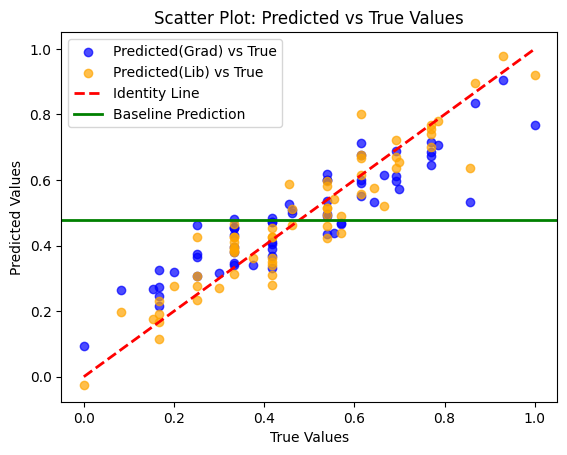

In [15]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test' are NumPy arrays or similar data structures

# Scatter plot of predicted vs true values
plt.scatter(y, Y, color='blue', label='Predicted(Grad) vs True',alpha=0.7)
plt.scatter(y, Y_lib, color='orange',label='Predicted(Lib) vs True',alpha=0.7)

print([min(y), max(y)])

# identity line
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', linewidth=2, label='Identity Line')

# The baseline predictions line
baseline_prediction = np.mean(y)
plt.axhline(y=baseline_prediction, color='green', linestyle='-', linewidth=2, label='Baseline Prediction')


plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Predicted vs True Values')
plt.legend()
plt.show()

## Model performance - predicted values Vs. redisuals

The scatter plot below displays the residuals (errors) plotted against predicted values. When the residuals cluster around the zero line, it suggests that either the data exhibits a predictive pattern or the model hypothesis effectively captures the variance in the data. A concentration of residuals near the zero line indicates a good agreement between the model's predictions and the actual values, signifying a well-fitted model.

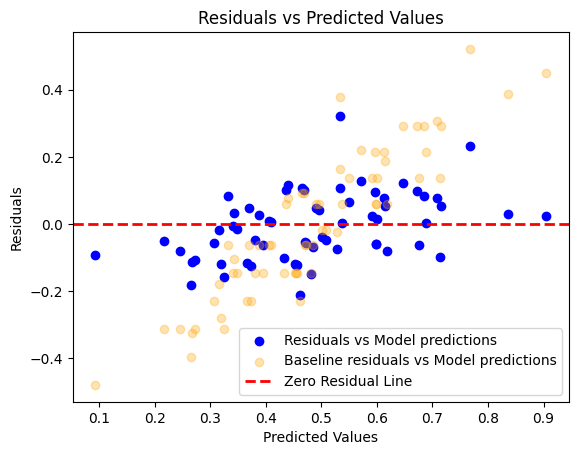

In [16]:
residuals = y - Y
baseline_residuals = y - baseline_prediction


# predicted vs residuals
plt.scatter(Y, residuals, color='blue', label='Residuals vs Model predictions')
plt.scatter(Y, baseline_residuals, color='orange', label='Baseline residuals vs Model predictions', alpha = 0.3)
# Horizontal line at y=0 for reference
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()

# AdaBoost with Sahllow Regression Trees

Algorithm: https://www.researchgate.net/publication/4116773_AdaBoostRT_A_boosting_algorithm_for_regression_problems
https://citeseerx.ist.psu.edu/pdf/8d49e2dedb817f2c3330e74b63c5fc86d2399ce3

AdaBoost R2: works by combining the predictions of weak regressors. Instead of using the entire dataset for training each weak regressor, AdaBoost.R2 employs bootstrap sampling. It sequintially fits weak regressors based on bootstraped sample. Bootstrap distribution follows pre-computed weight. The weights are initially set uniformly, and after each weak regressor is trained, the weights are updated. The weights are adjusted to give more importance to data points that were poorly predicted by the ensemble so far. By assigning higher weights to data points that were poorly predicted, AdaBoost.R2 ensures that the next weak regressor will focus more on correcting the mistakes made by the ensemble up to that point. The final prediction is computed by taking a weighted median of the predictions from all weak regressors. The weights are determined based on the performance of each regressor, with better-performing regressors receiving higher weights.

## Regression Stump
A "regression stump" is simply a binary split of feature. It finds both feature and a split within the chosen feature that minimizes the loss. The split is based on a particular feature and a threshold value.

In [17]:
from sklearn.metrics import mean_squared_error
from collections import deque
import numpy as np

class RegressionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.output_value = None

    def fit(self, X, y, loss_function = "squared"):
        num_samples, num_features = X.shape
        loss_best = float('inf')

        if num_samples == 1:
          self.output_value = y[0]
          return

        for feature_index in range(num_features):
            # Sort the feature values and corresponding labels
            sorted_indices = np.argsort(X[:, feature_index])
            sorted_labels = y[sorted_indices]

            for i in range(1, num_samples):
                # Set the threshold as the midpoint between consecutive feature values.
                threshold = (X[sorted_indices[i - 1], feature_index] + X[sorted_indices[i], feature_index]) / 2.0

                # Make predictions based on the split and compute average squared loss.
                predictions_left = np.mean(sorted_labels[:i])
                predictions_right = np.mean(sorted_labels[i:])
                if loss_function == "squared":
                  loss = (np.sum((predictions_left - sorted_labels[:i]) ** 2) + np.sum((predictions_right - sorted_labels[i:]) ** 2))/num_samples
                else:
                  loss = (np.sum(np.abs(predictions_left - sorted_labels[:i])) + np.sum(np.abs(predictions_right - sorted_labels[i:])))/num_samples

                # print(num_samples,feature_index,i,mse,loss_best,predictions_left)

                # Update the best split based on average squared loss.
                if loss < loss_best:
                    loss_best = loss
                    self.feature_index = feature_index
                    self.threshold = threshold
                    self.output_value = (predictions_left, predictions_right)
    def predict(self, X):
        if self.feature_index is None or self.threshold is None:
          return self.output_value
        output = np.where(X[:, self.feature_index] <= self.threshold, self.output_value[0], self.output_value[1])
        return output

## Regression Tree
A "regression tree" is a recursive tree structure. The tree is built by recursively splitting the dataset into subsets based on a particular feature and a threshold value. The root node is a simple regression stump fitted to the entire dataset. Each child node of the tree is another regression stump fitted to a subset of the data resulting from a split at a parent node. It greedily finds best splits since it is computationally heavy to consider all possible splits.

In [18]:
class tree_node:
  def __init__(self):
    self.stump = RegressionStump()
    self.left = None
    self.right = None

  def get_stump(self,X,Y):
    self.stump.fit(X, Y)

class regression_tree:
  def __init__(self, max_depth = 1):
    self.root = tree_node()
    self.max_depth = max_depth
    self.X = None
    self.Y = None
  def build_tree(self, X, Y):
    self.X = X
    self.Y = Y
    self.root.get_stump(X,Y)

    queue = deque()
    queue.append((self.root, X,Y, 1))

    while queue:
      node, X_stump, Y_stump, depth = queue.popleft()
      num_train = Y_stump.shape[0]
      if depth >= self.max_depth or num_train<2:
        continue
      feature_index = node.stump.feature_index
      threshold = node.stump.threshold
      left_mask = X_stump[:, feature_index] <= threshold
      right_mask = ~left_mask

      # Left and right subsets of the data
      X_left, Y_left = X_stump[left_mask], Y_stump[left_mask]
      X_right, Y_right = X_stump[right_mask], Y_stump[right_mask]

      if np.any(left_mask):
        node.left = tree_node()
        node.left.get_stump(X_left,Y_left)
        queue.append((node.left, X_left,Y_left, depth+1))

      if np.any(right_mask):
        node.right = tree_node()
        node.right.get_stump(X_right,Y_right)
        queue.append((node.right, X_right,Y_right, depth+1))
  def predict(self, X):
    return self.predict_tree(self.root, X)

  def predict_tree(self,node, X):
    if node.left is None and node.right is None:
        return node.stump.predict(X)
    else:
        left_mask = X[:, node.stump.feature_index] <= node.stump.threshold
        right_mask = ~left_mask
        predictions = np.zeros(X.shape[0])

        if np.any(left_mask) and node.left is not None:
            predictions[left_mask] = self.predict_tree(node.left, X[left_mask])

        if np.any(right_mask) and node.right is not None:
            predictions[right_mask] = self.predict_tree(node.right, X[right_mask])

        return predictions

In [19]:
# Get training data and test data
X_train = df_training_scaled[["TotalPoints","ScoringDefRank","PointsPerGame","AvgPointsPerGameAllowed"]].to_numpy()
y_train = df_training_scaled['winRate'].to_numpy()
X_test = df_testing_scaled[["TotalPoints","ScoringDefRank","PointsPerGame","AvgPointsPerGameAllowed"]].to_numpy()
y_test = df_testing_scaled['winRate'].to_numpy()

In [20]:
#Test Regression Stump
print("Fit a Regression Stump on Training Data.")
reg_stump = RegressionStump()
reg_stump.fit(X_train, y_train)

# Training Error - regression stump

predictions_stump = reg_stump.predict(X_train)

mse_stump = mean_squared_error(y_train, predictions_stump)
print(f"Avg. Training Error: {mse_stump}")

print("Fit a deeper regression tree.")
max_depth = 100
reg_tree = regression_tree(max_depth=max_depth)
reg_tree.build_tree(X_train, y_train)

# Training Error - regression tree
predictions = reg_tree.predict(X_train)

mse_tree = mean_squared_error(y_train, predictions)
print(f"Avg. Training Error: {mse_tree}")

Fit a Regression Stump on Training Data.
Avg. Training Error: 0.030529651878932453
Fit a deeper regression tree.
Avg. Training Error: 0.00040773535838920926


## Boosting

In [21]:
def weighted_median(values, weights):

    sorted_indices = values.argsort()
    values = values[sorted_indices]
    weights = weights[sorted_indices]
    weights_cumulative_sum = weights.cumsum()
    median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2) #finds first occurence where cumulative sum is greater than median.
    return values[median_weight]

In [22]:
class AdaBoostR2:

    def fit(self, X_train, y_train, T = 100, max_depth=2, rand_seed = None):

        self.y_train = y_train
        self.X_train = X_train
        self.T = T
        self.maxdepth = max_depth
        self.N, self.D = X_train.shape
        self.distribution = np.repeat(1/self.N, self.N)
        np.random.seed(rand_seed)

        self.trees = []
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        for t in range(self.T):

            ## Draw sample, fit tree, get predictions
            bootstrap_indices = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.distribution)
            bootstrap_X = self.X_train[bootstrap_indices]
            bootstrap_y = self.y_train[bootstrap_indices]
            # tree = RegressionStump()
            tree = regression_tree(max_depth= self.maxdepth)
            tree.build_tree(bootstrap_X, bootstrap_y)
            self.trees.append(tree)
            yhat = tree.predict(X_train)
            self.fitted_values[:,t] = yhat

            ## Calculate observation errors
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t/D_t

            ## Calculate model error (and possibly break)
            Lbar_t = np.sum(self.distribution*L_ts)
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:,:t-1]
                self.trees = self.trees[:t-1]
                break

            ## Calculate and record beta (model weight)
            ## Note: lower beta_t -> greater confidence in current predictor.
            beta_t = Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)

            ## Compute new weight(distribution) and normalize.
            ## Note: greater L_ts (scaled absolute error) implies greater weight.
            ## (1-L_ts) term in the exponent tends to 0.
            Z_t = np.sum(self.distribution*beta_t**(1-L_ts))
            self.distribution *= beta_t**(1-L_ts)/Z_t


        ## Get weighted median.
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])

    def predict(self, X):
        N_pred = len(X)
        fitted_values = np.empty((N_pred, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:,t] = tree.predict(X)
        return np.array([weighted_median(fitted_values[n], self.model_weights) for n in range(N_pred)])

## Fit the model

In [23]:
booster = AdaBoostR2()
booster.fit(X_train, y_train, T = 15, max_depth=5, rand_seed = 42)
predictions = booster.predict(X_test)

# Test Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Baseline Error
baseline_predictions = np.mean(y_test)
mse_baseline = mean_squared_error(y_test, np.full_like(y_test, baseline_predictions))

print("Test Error:", mse)
print("Baseline Error:", mse_baseline)
print("Explained Proportion:", (mse_baseline-mse)/mse_baseline)
## test R^2

Test Error: 0.007293012572436106
Baseline Error: 0.04721241608983643
Explained Proportion: 0.8455276561453906


## Model performance - predicted values Vs. true values

The scatter plot below compares predicted values against true values, while the identity line represents instances where the predicted value exactly matches the true value. A close alignment of the data points with the identity line is indicative of accurate predictions. If the scatter plot closely resembles the identity line, it suggests that the model's predictions are in strong agreement with the actual values.

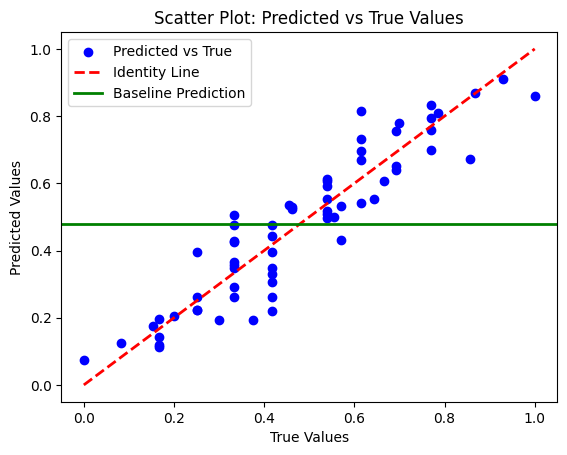

In [24]:
import matplotlib.pyplot as plt

# predicted vs true
plt.scatter(y_test, predictions, color='blue', label='Predicted vs True')

# identity line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Identity Line')

# The baseline predictions line
baseline_prediction = np.mean(y_test)
plt.axhline(y=baseline_prediction, color='green', linestyle='-', linewidth=2, label='Baseline Prediction')


plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Predicted vs True Values')
plt.legend()
plt.show()

## Model performance - predictev values Vs. redisuals

The scatter plot below displays the residuals (errors) plotted against predicted values. When the residuals cluster around the zero line, it suggests that the model hypothesis effectively captures the variance in the data. A concentration of residuals near the zero line indicates a good agreement between the model's predictions and the actual values, signifying a well-fitted model.

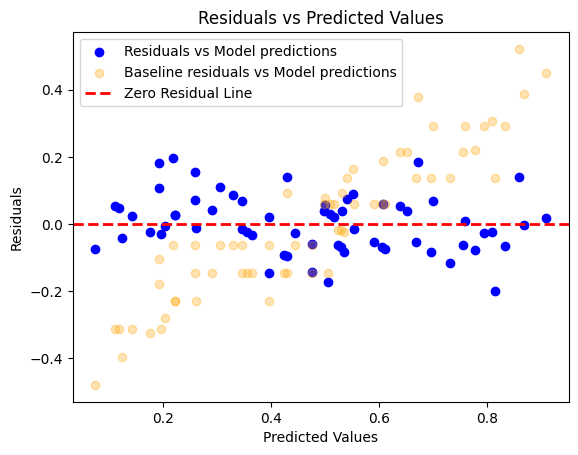

In [25]:
residuals = y_test - predictions
baseline_residuals = y_test - baseline_prediction

# predicted vs residuals
plt.scatter(predictions, residuals, color='blue', label='Residuals vs Model predictions')
plt.scatter(predictions, baseline_residuals, color='orange', label='Baseline residuals vs Model predictions', alpha = 0.3)

# Horizontal line at y=0 for reference
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()